# Analisis de Sentimientos

Autor: Gilberto Nava Marcos

En este notebook se analizan los sentimientos de los tweets de los usuarios de Twitter. Para ello se utiliza la librería de Python [TextBlob](https://textblob.readthedocs.io/en/dev/).

Los datos se encuentran almacenados en una base de datos en MySQL. Para acceder a los datos se utiliza la librería [MySQL Connector](https://dev.mysql.com/doc/connector-python/en/connector-python-example-connecting.html).

Los graficos se generan con la librería [Plotly](https://plot.ly/python/).
Los graficos se generan con la libreria [Matplotlib](https://matplotlib.org/).


## Conexion con la Base de Datos

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from googletrans import Translator
from sqlalchemy import create_engine, inspect

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

In [2]:
# Conexion a la base de datos 
engine = create_engine('mysql+mysqlconnector://root@localhost:3306/twitter_db')

# Inspector de la base de datos
inspector = inspect(engine)

In [3]:
# Obtenemos los nombres de las tablas de la base de datos
print(inspector.get_table_names())

['tweets_gpt4', 'tweets_oscars', 'tweets_otan']


In [4]:
# Consulta almacenada en un dataframe para una mejor manipulación
df = pd.read_sql_query('SELECT * FROM twitter_db.tweets_gpt4', engine)
df.head()

id                       Date         Username  \
0   1  2023-03-15 07:59:02+00:00    MelonieDodaro   
1   2  2023-03-15 07:58:58+00:00  JonAttenborough   
2   3  2023-03-15 07:58:58+00:00   RobertClauburg   
3   4  2023-03-15 07:58:57+00:00       PKommentar   
4   5  2023-03-15 07:58:50+00:00   mindfrozentime   

                                               Tweet            Polarity  \
0  🎯 Sales pros, meet your new secret weapon: Cha...  0.0037878787878787   
1  I consider myself somewhat of an expert on AI ...               0.575   
2  New MIT Research Shows Spectacular Increase In...  0.2454545454545454   
3  It's like one of these mornings that you wake ...                 0.0   
4  AI Tokens Skyrocket Following the Launch of Ch...                 0.0   

         Subjectivity  
0  0.3848484848484848  
1               0.575  
2  0.4515151515151515  
3                 0.0  
4                 0.1

## Analisis Exploratorio de Datos

In [5]:
# Mostramos informacion relevante del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   Date          50000 non-null  object
 2   Username      50000 non-null  object
 3   Tweet         50000 non-null  object
 4   Polarity      50000 non-null  object
 5   Subjectivity  50000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.3+ MB


In [6]:
# Descripcion estadistica del dataframe
# Este dato no nos ayuda mucho de momento ya que no tenemos datos numericos
df.describe()

id
count  50000.000000
mean   25000.500000
std    14433.901067
min        1.000000
25%    12500.750000
50%    25000.500000
75%    37500.250000
max    50000.000000

In [7]:
# Separamos la fecha y la hora de la columna Date 
df['Date'] = pd.to_datetime(df['Date'])

df['Hora'] = df['Date'].dt.time
df['Fecha'] = df['Date'].dt.date


In [8]:
df.head()

id                      Date         Username  \
0   1 2023-03-15 07:59:02+00:00    MelonieDodaro   
1   2 2023-03-15 07:58:58+00:00  JonAttenborough   
2   3 2023-03-15 07:58:58+00:00   RobertClauburg   
3   4 2023-03-15 07:58:57+00:00       PKommentar   
4   5 2023-03-15 07:58:50+00:00   mindfrozentime   

                                               Tweet            Polarity  \
0  🎯 Sales pros, meet your new secret weapon: Cha...  0.0037878787878787   
1  I consider myself somewhat of an expert on AI ...               0.575   
2  New MIT Research Shows Spectacular Increase In...  0.2454545454545454   
3  It's like one of these mornings that you wake ...                 0.0   
4  AI Tokens Skyrocket Following the Launch of Ch...                 0.0   

         Subjectivity      Hora       Fecha  
0  0.3848484848484848  07:59:02  2023-03-15  
1               0.575  07:58:58  2023-03-15  
2  0.4515151515151515  07:58:58  2023-03-15  
3                 0.0  07:58:57  2023-03-15  
4                 0.1  07:58:50  2023-03-15

In [10]:
# Wordcloud con las palabras mas usadas en los tweets
stop_words = set(stopwords.words('english'))
# Descartamos las palabras que no nos interesan: RT, https, gtp, chat gtp, co
stop_words.update(['rt', 'https', 'gtp', 'chat', 'co', 'gpt', 'gpt4', 'gpt4chat', 'gpt4chatbot', 'gpt4bot', 'gpt4bot', 'chatgpt plus', 'chat gpt plus'])

palabras = ' '.join([word.lower() for val in df['Tweet'] for word in val.split() if word.lower() not in stop_words])


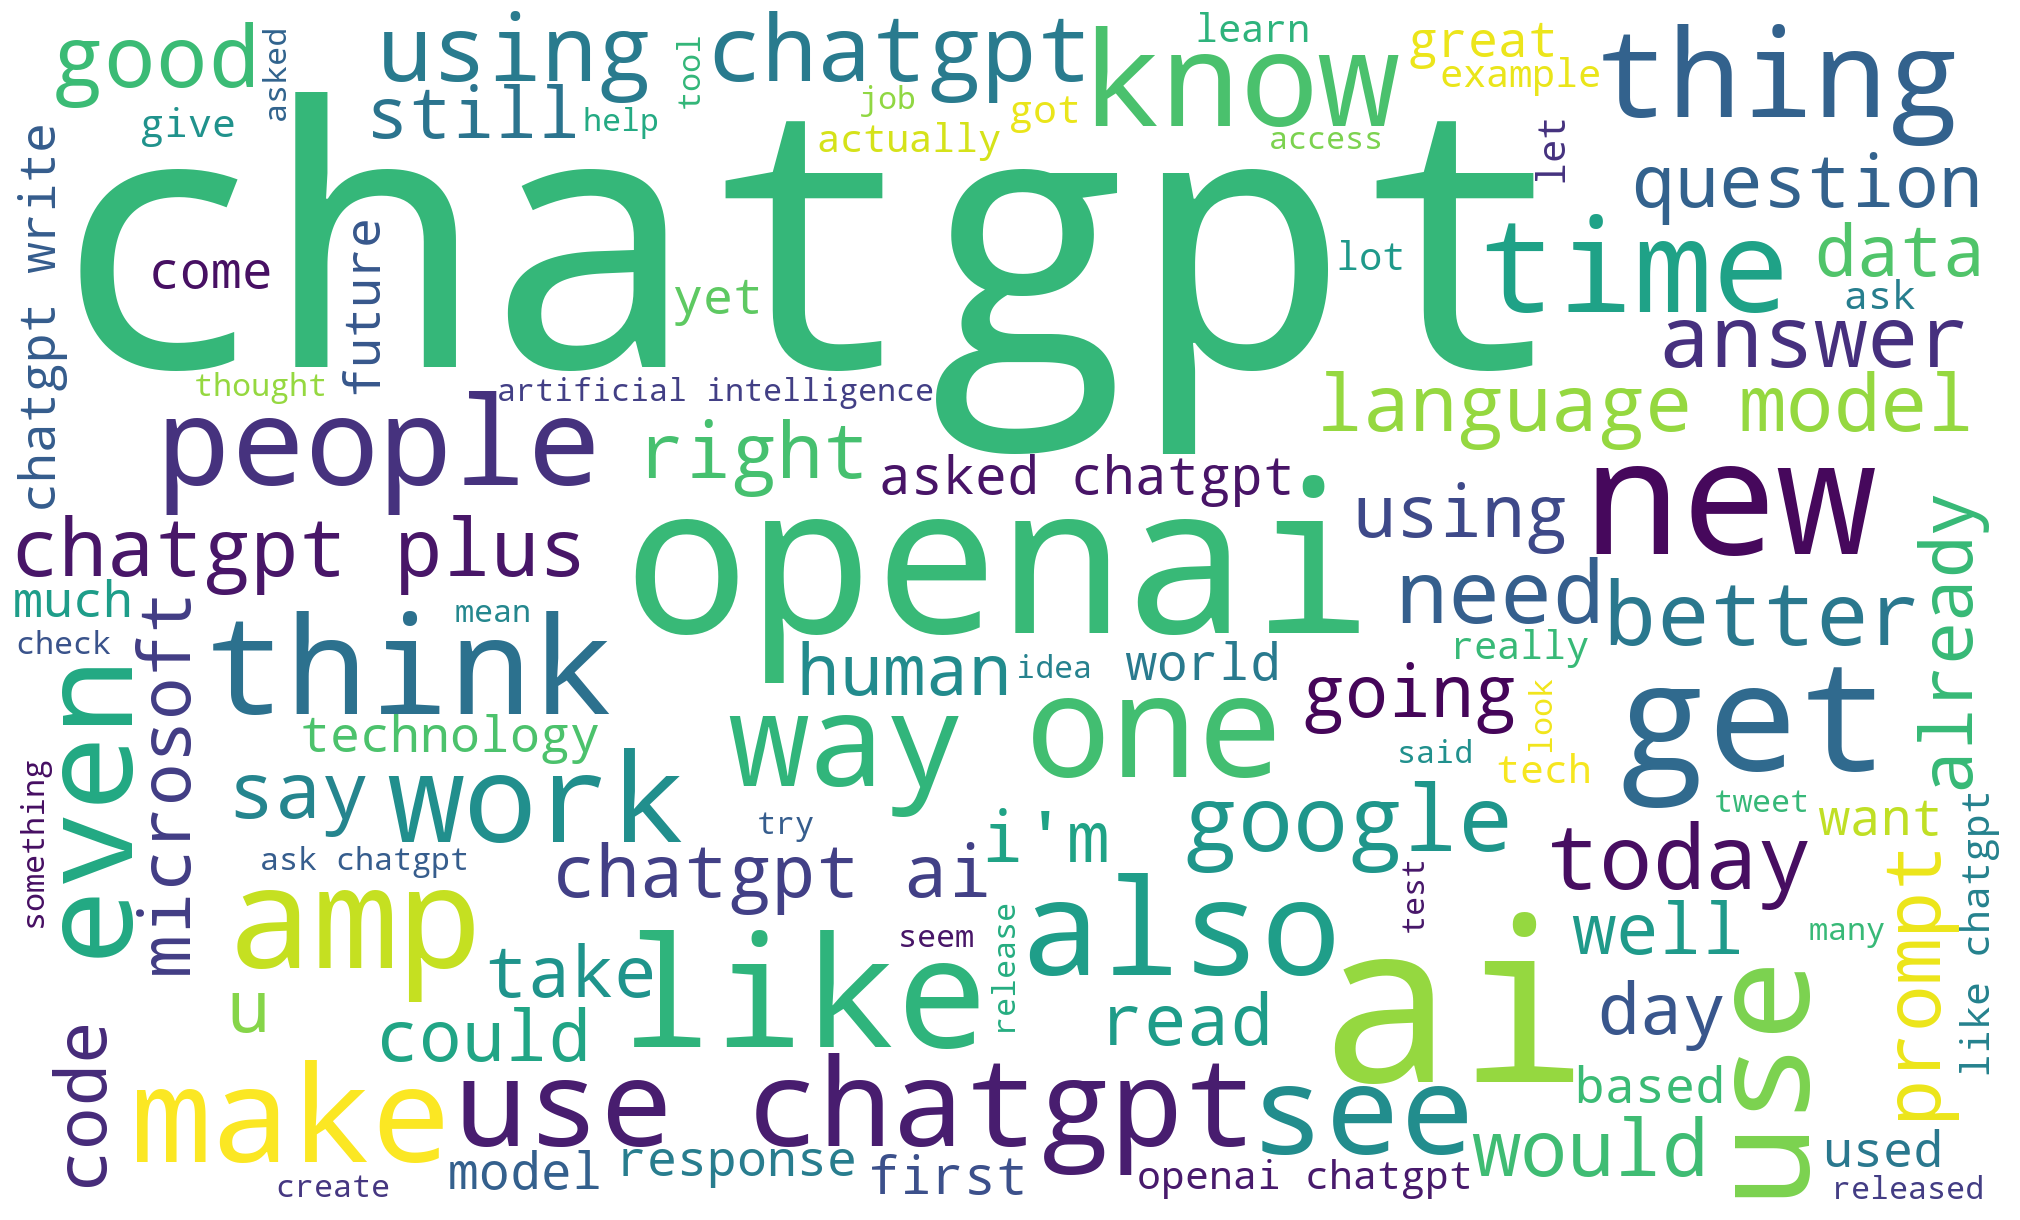

In [11]:
# Generamos el wordcloud con las palabras mas usadas en los tweets
wordcloud = WordCloud(width = 2_000, height = 1_200,
                background_color ='white',
                stopwords = stop_words,
                max_words=100,
                min_font_size = 0,
                ).generate(palabras)

# Mostramos la imagen
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()        

In [78]:
# Grafico de barras con los 10 Usernames que mas Tweets han publicado con plotly (excluyendo el maine4568 que es un bot banneado)
fig = px.bar(df['Username'].value_counts().head(10).drop('maine4568'), 
            title='Top 10 Cuentas que más Tweets han publicado',
            text_auto=True,
            x=df['Username'].value_counts().head(10).drop('maine4568').index, 
            y=df['Username'].value_counts().head(10).drop('maine4568').values, 
            labels={'x':'Username', 'y':'Tweets'})
fig.show()

In [31]:
# Horario en el que mas se publicaron los tweets
# Redondeamos los minutos de la hora para que sea mas facil de leer
df['Hora'] = df['Hora'].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
df['Hora'].value_counts().head(20)


17:00:00    4877
18:00:00    4819
19:00:00    4327
20:00:00    3959
21:00:00    3311
22:00:00    2670
23:00:00    2342
07:00:00    2207
00:00:00    2065
06:00:00    2038
01:00:00    2010
03:00:00    1927
02:00:00    1907
05:00:00    1888
04:00:00    1815
16:00:00    1325
15:00:00    1076
14:00:00    1054
13:00:00    1003
12:00:00     840
Name: Hora, dtype: int64

In [82]:
# Mapa de calor con el horario en el que mas se publicaron los tweets con plotly
# Ordenamos el dataframe por la hora para que se vea mejor el mapa de calor
df = df.sort_values(by='Hora')

fig = px.density_heatmap(df, title='Mapa de calor con Twits por hora', text_auto=True ,x="Hora", y="Fecha", nbinsx=24, nbinsy=3, color_continuous_scale="aggrnyl")
fig.show()

In [85]:
# Clasificamos el contenido de Tweets en positivo, negativo y neutro

# Creamos una funcion para clasificar el contenido de los tweets
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Creamos una nueva columna en el dataframe con el resultado de la funcion
df['Sentiment'] = df['Tweet'].apply(get_sentiment)

# Creamos una nueva columna en el dataframe con la clasificacion del tweet
df['Sentiment'] = df['Sentiment'].apply(lambda x: 'Positivo' if x > 0 else ('Negativo' if x < 0 else 'Neutro'))

# Mostramos los resultados
df.head()

id                      Date      Username  \
11846  11847 2023-03-15 00:22:49+00:00   johnytiger_   
11938  11939 2023-03-15 00:19:38+00:00     mattbeane   
11937  11938 2023-03-15 00:19:38+00:00      trainin9   
11936  11937 2023-03-15 00:19:39+00:00  SaveToNotion   
11935  11936 2023-03-15 00:19:42+00:00   RonChrisley   

                                                   Tweet            Polarity  \
11846                            there's already a gpt-4                 0.0   
11938  For example, Duolingo is a first-wave GPT-4 de...                 0.0   
11937  306 – The new Bing runs on OpenAI’s GPT-4 http...  0.1363636363636363   
11936  @Q_Qkell This thread is saved to your Notion d...               -0.75   
11935  If we start 0.1575 kms North, and go another ....                 0.5   

             Subjectivity      Hora       Fecha Sentiment  
11846                 0.0  00:00:00  2023-03-15    Neutro  
11938                 0.0  00:00:00  2023-03-15    Neutro  
11937  0.4545454545454545  00:00:00  2023-03-15  Positivo  
11936                 1.0  00:00:00  2023-03-15  Negativo  
11935                 1.0  00:00:00  2023-03-15  Positivo

In [95]:
# Grafico de Funnel con los resultados de la clasificacion de los tweets
fig = px.funnel(df['Sentiment'].value_counts(),
            title='Clasificacion de los Tweets',
            x=df['Sentiment'].value_counts().index,
            y=df['Sentiment'].value_counts().values,
            labels={'x':'Sentimiento', 'y':'Tweets'})
fig.show()

In [105]:
# Distribucion del numero de caracteres de los tweets
# Creamos una nueva columna en el dataframe con el numero de caracteres de los tweets
df['Num_Caracteres'] = df['Tweet'].apply(lambda x: len(x))

# Mostramos los resultados
df.head()


id                      Date      Username  \
11846  11847 2023-03-15 00:22:49+00:00   johnytiger_   
11938  11939 2023-03-15 00:19:38+00:00     mattbeane   
11937  11938 2023-03-15 00:19:38+00:00      trainin9   
11936  11937 2023-03-15 00:19:39+00:00  SaveToNotion   
11935  11936 2023-03-15 00:19:42+00:00   RonChrisley   

                                                   Tweet            Polarity  \
11846                            there's already a gpt-4                 0.0   
11938  For example, Duolingo is a first-wave GPT-4 de...                 0.0   
11937  306 – The new Bing runs on OpenAI’s GPT-4 http...  0.1363636363636363   
11936  @Q_Qkell This thread is saved to your Notion d...               -0.75   
11935  If we start 0.1575 kms North, and go another ....                 0.5   

             Subjectivity      Hora       Fecha Sentiment  Num_Caracteres  
11846                 0.0  00:00:00  2023-03-15    Neutro              23  
11938                 0.0  00:00:00  2023-03-15    Neutro             142  
11937  0.4545454545454545  00:00:00  2023-03-15  Positivo              65  
11936                 1.0  00:00:00  2023-03-15  Negativo              71  
11935                 1.0  00:00:00  2023-03-15  Positivo             149

In [118]:
# Grafico de barras con la distribucion del numero de caracteres de los tweets descartando los tweets con mas de 255 caracteres
# Descartamos los tweets con mas de 255 caracteres ya que son tweets que han sido cortados por el limite de caracteres de Twitter
df_caracters = df[df['Num_Caracteres'] <= 254]

fig = px.histogram(df_caracters, text_auto=True, x='Num_Caracteres', nbins=30, title='Distribución del número de caracteres de los Tweets')
fig.update_layout(xaxis_title='Número de caracteres', yaxis_title='Tweets')
fig.show()

# Grafico alterno con todos los tweets
fig = px.histogram(df, text_auto=True, x='Num_Caracteres', nbins=30, title='Distribución del número de caracteres de los Tweets (incluyendo los cortados)')
fig.update_layout(xaxis_title='Número de caracteres', yaxis_title='Tweets')
fig.show()